In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from models.model2 import BicycleModel
from models.model4 import FourWheelModel
from models.utils import get_csv_row_count
from models.utils import get_folder_path
from models.utils import fit_circle
from models.utils import plot_column_histograms
import time
import csv
import scipy.stats as sc

In [11]:
##FINAL VERSION WITH FITNESS FUNCTION NOT COMPUTED EVRY TIME
data_size = 100

np.random.seed(2)

class Particle:
    def __init__(self, position, velocity,id, dimension, ref_radius):
        # Necessary for all the particles iincluding thrash one
        self.dt = 0.025
        self.commands = get_folder_path()+'/open_loop_inputs/open_loop_commands.csv'
        self.N = get_csv_row_count(self.commands)
        self.open_loop_tf = self.N*self.dt

        dt = 0.05
        open_loop_tf = 10000
        T_peak = 0.37
        T_slope = 0.4

        self.ref_radius = ref_radius
        

        self.model4 = FourWheelModel(dt,open_loop_tf, T_peak, T_slope)

    
        self.position = position
        self.velocity = velocity
        self.best_position = position.copy()
        self.dimension =  dimension

            #related to vehicle model
        self.param_to_infer = 2
        self.model = None
            
        self.id = id

            
        self.position_cost_value = self.compute_fitness_function()
        self.best_position_cost_value = float(self.position_cost_value)


    def update_velocity(self, inertia, cognitive_rate, social_rate, global_best_position):
        r1, r2 = np.random.rand(2)
        cognitive_component = cognitive_rate * r1 * (self.best_position - self.position)
        social_component = social_rate * r2 * (global_best_position - self.position)
        self.velocity = inertia * self.velocity + cognitive_component + social_component

    def update_position(self, lower_bounds, upper_bounds):
        
        self.position += self.velocity
        self.position = np.clip(self.position, lower_bounds, upper_bounds)
        self.position_cost_value = self.compute_fitness_function()

    def update_best_position(self):
        if self.position_cost_value < self.best_position_cost_value:
            self.best_position = self.position.copy()
            self.best_position_cost_value = self.position_cost_value
    
    def compute_fitness_function(self):
        return float(self.get_kpi())
    
    def get_kpi(self):
        
        return (self.model4.kinematik_model_radius(self.position)-self.ref_radius)**2 #for dirac
    
    
class PSO:
    def __init__(self, num_particles, max_iterations, lower_bounds, upper_bounds, dimension, ref_radius):
        self.num_particles = num_particles
        self.max_iterations = max_iterations
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.dimension = dimension
        self.particles = []
        self.global_best_position = None
        self.global_best_position_cost = None


        self.particle_positions_history = []
        self.particle_fitness_history = []

        self.ref_radius = ref_radius




    #------------------OPTIMIZATION------------------#

    def optimize(self, inertia=0.5, cognitive_rate=0.5, social_rate=0.5):
        self.initialize_particles()

        for iter in range(self.max_iterations):
            
            self.particle_positions_history.append([ particle.position for particle in self.particles])
            self.particle_fitness_history.append([particle.position_cost_value for particle in self.particles])

            for particle in self.particles:
                particle.update_velocity(inertia, cognitive_rate, social_rate, self.global_best_position)
                particle.update_position(self.lower_bounds, self.upper_bounds)
                particle.update_best_position()

            self.update_global_best_position()
            if iter%10 == 0:
                print('Iteration: ', iter)

    def initialize_particles(self):
        self.particles = []
        
        

        t_before = time.time()
        for i in range(self.num_particles):
            
            position = np.random.uniform(self.lower_bounds, self.upper_bounds, size=self.dimension)
            velocity = np.zeros_like(position)
            id = i
            dimension = self.dimension
            particle = Particle(position, velocity, id, dimension, ref_radius=self.ref_radius)
            self.particles.append(particle)
        t_after = time.time()
        elapsed_time = t_after-t_before
        print('All particles are initialized in: ', elapsed_time, ' Expected time for inference: ', elapsed_time*self.max_iterations)
        

        index_best_initial_particle = np.argmin([ particle.position_cost_value for particle in self.particles])
        self.global_best_position = self.particles[index_best_initial_particle].position.copy()
        self.global_best_position_cost = self.particles[index_best_initial_particle].position_cost_value

    def update_global_best_position(self):
        for particle in self.particles:
            if particle.position_cost_value < self.global_best_position_cost:
                self.global_best_position = particle.position.copy()
                self.global_best_position_cost = particle.position_cost_value


    def plot_particle_positions(self, frame):
        plt.cla()
        positions = np.array(self.particle_positions_history[frame])
        for i in range(self.dimension):
            plt.plot(positions[:, i], np.zeros_like(positions[:, i]), 'go', markersize=6)
        plt.xlabel('x')
        plt.ylim([-0.5, 0.5])

    def plot_particle_fitness_history(self):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

        # Plot histogram at the start
        ax1.hist(self.particle_fitness_history[0], bins=20, color='blue', edgecolor='black')
        ax1.set_xlabel(r'Fitness')
        ax1.set_ylabel(r'Frequency')
        ax1.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(0))

        # Plot histogram at the middle
        middle_index = len(self.particle_fitness_history) // 2
        ax2.hist(self.particle_fitness_history[middle_index], bins=20, color='green', edgecolor='black')
        ax2.set_xlabel(r'Fitness')
        ax2.set_ylabel(r'Frequency')
        ax2.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(middle_index))
        ax2.ticklabel_format(useOffset=False)
        ax2.locator_params(nbins=4)

        # Plot histogram at the end
        ax3.hist(self.particle_fitness_history[-1], bins=20, color='red', edgecolor='black')
        ax3.set_xlabel(r'Fitness')
        ax3.set_ylabel(r'Frequency')
        ax3.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(len(self.particle_positions_history)))
        ax3.ticklabel_format(useOffset=False)
        ax3.locator_params(nbins=3)

        plt.tight_layout()
        plt.show()


    def plot_particle_history(self):
        if self.dimension == 1:
            self.particle_positions_history = np.array(self.particle_positions_history)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

            # Plot histogram at the start
            ax1.hist(self.particle_positions_history[0], bins=20, color='blue', edgecolor='black')
            ax1.set_xlabel(r'$\theta \rm [rad]$')
            ax1.set_ylabel(r'Frequency')
            ax1.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(0))

            # Plot histogram at the middle
            middle_index = len(self.particle_positions_history) // 2
            ax2.hist(self.particle_positions_history[middle_index], bins=20, color='green', edgecolor='black')
            ax2.set_xlabel(r'$\theta \rm [rad]$')
            ax2.set_ylabel(r'Frequency')
            ax2.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(middle_index))
            ax2.ticklabel_format(useOffset=False)
            ax2.locator_params(nbins=4)

            # Plot histogram at the end
            ax3.hist(self.particle_positions_history[-1], bins=20, color='red', edgecolor='black')
            ax3.set_xlabel(r'$\theta \rm [rad]$')
            ax3.set_ylabel(r'Frequency')
            ax3.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(len(self.particle_positions_history)))
            plt.ticklabel_format(useOffset=False)
            ax3.locator_params(nbins=4)



            plt.tight_layout()
            plt.show()


        if self.dimension == 2:
            self.particle_positions_history = np.array(self.particle_positions_history)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
            # Plot histogram at the start
            ax1.hist2d(self.particle_positions_history[0][:, 0], self.particle_positions_history[0][:, 1], bins=20, cmap='viridis')
            ax1.set_xlabel(r'$T_{peak}$')
            ax1.set_ylabel(r'$T_{front}$')
            ax1.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(0))

            # Plot histogram at the middle
            middle_index = len(self.particle_positions_history) // 2
            ax2.hist2d(self.particle_positions_history[middle_index][:, 0],self.particle_positions_history[middle_index][:, 1], bins=20, cmap='viridis')
            ax2.set_xlabel(r'$T_{peak}$')
            ax2.set_ylabel(r'$T_{front}$')
            ax2.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(middle_index))

            # Plot histogram at the end
            ax3.hist2d(self.particle_positions_history[-1][:, 0], self.particle_positions_history[-1][:, 1], bins=20, cmap='viridis')
            ax3.set_xlabel(r'$T_{peak}$')
            ax3.set_ylabel(r'$T_{front}$')
            ax3.set_title(r'$\mathrm{{Iteration}}\ {0}$'.format(len(self.particle_positions_history)))

            plt.tight_layout()
            plt.show()

    def plot_particle_positions_animate(self):
        self.X, self.Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
        self.Z = self.X**2 + self.Y**2

        fig = plt.figure()
        ani = FuncAnimation(fig, self.plot_particle_positions, frames=len(self.particle_positions_history), interval=200)
        plt.show()

    def save_to_csv(self, path):
        iteration = self.max_iterations
        num_particles = self.num_particles
        particles_positions = self.particle_positions_history.reshape(-1,2)

        # Define the CSV file path
        csv_file = path

        # Write data to CSV file
        with open(csv_file, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['T_peak', 'T_front', 'Iteration', 'Particles'])
            writer.writerow([particles_positions[0, 0], particles_positions[0, 1], iteration, num_particles])
            writer.writerows(particles_positions[1:])

        print(f"Data saved to {csv_file}.")




In [37]:
# INference
dt = 0.05
open_loop_tf = 10000
T_peak = 0.37
T_slope = 0.4
data_size = 1
model4 = FourWheelModel(dt, open_loop_tf, T_peak, T_slope)

#Data generation
steering = np.full(data_size,0.1)

for i in range(len(steering)):
    steering[i] += 0 #np.random.normal(0,0.005)

# obtain response and add noise
y_likelihood = np.zeros(data_size)
for i in range(len(steering)):
    y_likelihood[i] = model4.kinematik_model_radius(steering[i])
y_likelihood.reshape(-1,1) 



# Example usage
upper_bouds_1d = 1
lower_bouds_1d = 0.00
upper_bouds_2d = [0.5,10]
lower_bouds_2d = [0.,0]






#pso.save_to_csv('./Results/PSO/iter50particle10.csv')

#pso.particle_positions_history[len(pso.particle_positions_history)-1]

history_list = []
for i in range(len(y_likelihood)):
    pso = PSO(num_particles=20, max_iterations=100, lower_bounds=lower_bouds_1d, upper_bounds=upper_bouds_1d, dimension=1, ref_radius=y_likelihood[i])
    pso.optimize()
    #pso.plot_particle_history()
    history_list.append(pso.particle_positions_history)



All particles are initialized in:  0.17703866958618164  Expected time for inference:  8.851933479309082
Iteration:  0
Iteration:  10
Iteration:  20
Iteration:  30
Iteration:  40


Text(0.5, 1.0, 'Infered distribution')

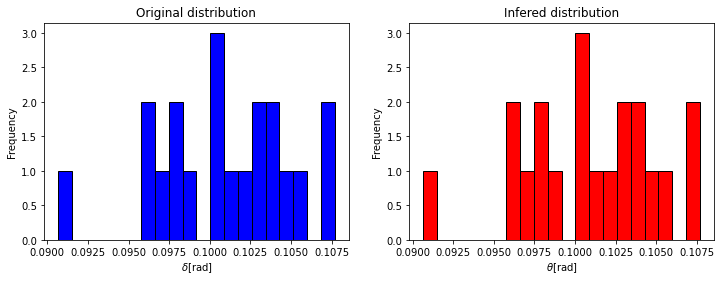

In [35]:
x = np.arange(0,len(history_list), 1)
means = []
for i in range(len(x)):
     means.append(np.mean(np.array((history_list[i][len(history_list)]))))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(means, bins=20,  color='blue', edgecolor='black')
ax1.set_xlabel(r'$\delta \rm [rad]$')
ax1.set_ylabel(r'Frequency')
ax1.set_title(r'Original distribution'.format(0))
ax2.hist(steering, bins=20,  color='red', edgecolor='black')
ax2.set_xlabel(r'$\theta \rm [rad]$')
ax2.set_ylabel(r'Frequency')
ax2.set_title(r'Infered distribution'.format(0))

(array([1., 0., 0., 0., 0., 0., 2., 1., 2., 1., 0., 3., 1., 1., 2., 2., 1.,
        1., 0., 2.]),
 array([0.09065519, 0.09150719, 0.09235919, 0.09321119, 0.09406319,
        0.09491519, 0.09576719, 0.09661919, 0.09747118, 0.09832318,
        0.09917518, 0.10002718, 0.10087918, 0.10173118, 0.10258318,
        0.10343518, 0.10428718, 0.10513918, 0.10599118, 0.10684317,
        0.10769517]),
 <BarContainer object of 20 artists>)

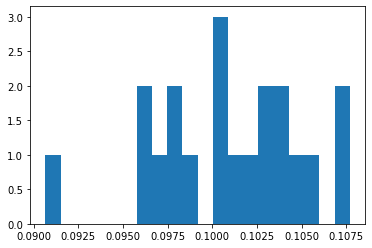

In [29]:

plt.hist(steering,bins=20)

In [148]:
res = sc.norm.fit(pso.particle_positions_history[len(pso.particle_positions_history)-1])
res

(0.09881319387734996, 0.0028138296511636893)

In [22]:
proposed_radius = self.model4.kinematik_model_radius(self.position[0])
print('proposed radius', proposed_radius)
mean = np.full(self.x_vect_ref.shape[0], proposed_radius).reshape(-1,1)


lhd_out = sc.norm.logpdf(self.x_vect_ref, loc= mean, scale= self.position[1])


#print("np.full",end_time1-start_time1)
#print("lhdout",end_time2-end_time1)

# then we sum lhd_out (be careful here, we are summing instead of multiplying
# because we are dealing with the log-likelihood, instead of the raw likelihood).
lhd_out = np.sum(lhd_out)
print(lhd_out)

array([[-2.79415220e-06],
       [ 3.03699289e-01],
       [-1.59247341e-30],
       [-9.79988670e-29],
       [ 2.02845784e-01],
       [-7.16740435e-31],
       [-1.10085860e-25],
       [ 3.28309937e-01],
       [-6.66768399e-28],
       [-2.91954501e-29],
       [-6.74116444e-31],
       [-1.84659307e-30],
       [-9.94913333e-31],
       [ 3.32563224e-01],
       [-4.37287479e-03],
       [-2.60031698e-31],
       [-4.02838473e-31],
       [-3.10613085e-24],
       [-5.24507084e-31],
       [-5.24759677e-11]])

In [67]:
dt = 0.05
open_loop_tf = 10000
T_peak = 0.37
T_slope = 0.4


model4 = FourWheelModel(dt, open_loop_tf, T_peak, T_slope)
steering = np.full(data_size,0.1)

for i in range(len(steering)):
    steering[i] += 0 #np.random.normal(0,0.005)

# obtain response and add noise
y_likelihood = np.zeros(data_size)
for i in range(len(steering)):
    y_likelihood[i] = model4.kinematik_model_radius(steering[i])

# x is the data matrix, first column for input and second column for output.
# theta is a vector containing the parameters for the evaluation
# remember theta[0] is a, theta[1] is b and theta[2] is sigma

proposed_radius = model4.kinematik_model_radius(0.1)
print('proposed radius', proposed_radius)
mean = np.full(y_likelihood.shape[0], proposed_radius).reshape(-1,1)


lhd_out = sc.norm.logpdf(y_likelihood, loc= mean, scale= 0.005)

# then we sum lhd_out (be careful here, we are summing instead of multiplying
# because we are dealing with the log-likelihood, instead of the raw likelihood).
lhd_out = np.sum(lhd_out)/10000


print(lhd_out)

proposed radius 15.267759048747639
4.379378833343365


In [ ]:
plt.plot()